# Stacking [(ARIMAX + RNN) --> LR]

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, pacf
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
import keras

In [2]:
#2. Import dataset
data = pd.read_csv("D:\Tài liệu PTDLKD\Data_stock_VJC_VN.csv")
data

,time,open,high,low,close,volume
0,2019-03-01,117964,118955,115981,118955,1125320
1,2019-03-04,119451,120145,118658,119847,990660
2,2019-03-05,119550,119649,118459,118955,1074790
3,2019-03-06,118955,119946,118955,119946,939310
4,2019-03-07,119946,120541,119847,120343,1014890
...,...,...,...,...,...,...
1247,2024-02-23,103800,104400,103400,103800,670800
1248,2024-02-26,103900,104900,103900,104500,605600
1249,2024-02-27,104800,104800,103500,103500,647800
1250,2024-02-28,103500,104700,103300,103400,638600


# ARIMAX

In [3]:
#3. Partition the data into necessary segments
ratio = 0.9
split = int(len(data)*ratio)

x_train_a = data[:split].index
y_train_a = data[:split][['close']]
exg_train_a = data[:split][['high','low']]

x_test_a = data[split:].index
y_test_a = data[split:][['close']]
exg_test_a = data[split:][['high','low']]

In [4]:
#4. Function for adf testing
def adf_test(dataset):
    dftest =  adfuller (dataset, autolag='AIC') 
    print("1. ADF: ",dftest[0])
    print("2. P-Value: ", round (dftest[1],6))
    print("3. Num Of Lags: ", dftest[2])
    print("4. Critical Values :")
    for key, val in dftest [4].items():
        print("\t",key, ":", val)
    if (dftest[0] < dftest [4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]): 
        print ("Reject H0: Time Series is Stationary")
        return True
    else:
        print ("Failed to Reject H0: Time Series is Non-Stationary") 
        return False

In [5]:
#5. Check the stationarity of the data and determine d
diff_order = 0
is_stationary = False
while not is_stationary:
    if diff_order > 0:
        train_diff = pd.DataFrame(np.diff(y_train_a['close'], diff_order))
        train_diff.index = y_train_a.index[diff_order:]
        train_diff.columns = ['close']
        diff = train_diff
    else:
        diff = y_train_a

    print('-' * 50)
    print('Difference order:', diff_order) 
    if adf_test(diff['close']):
        is_stationary =  True
    else:
        diff_order += 1
print('-' * 50)
print('Choose d =', diff_order)

--------------------------------------------------
Difference order: 0
1. ADF:  -1.7980657655242807
2. P-Value:  0.381422
3. Num Of Lags:  7
4. Critical Values :
	 1% : -3.4362125920049498
	 5% : -2.8641286575615426
	 10% : -2.5681482759591785
Failed to Reject H0: Time Series is Non-Stationary
--------------------------------------------------
Difference order: 1
1. ADF:  -12.78861238355275
2. P-Value:  0.0
3. Num Of Lags:  6
4. Critical Values :
	 1% : -3.4362125920049498
	 5% : -2.8641286575615426
	 10% : -2.5681482759591785
Reject H0: Time Series is Stationary
--------------------------------------------------
Choose d = 1


Text(0.5, 1.0, 'PACF')

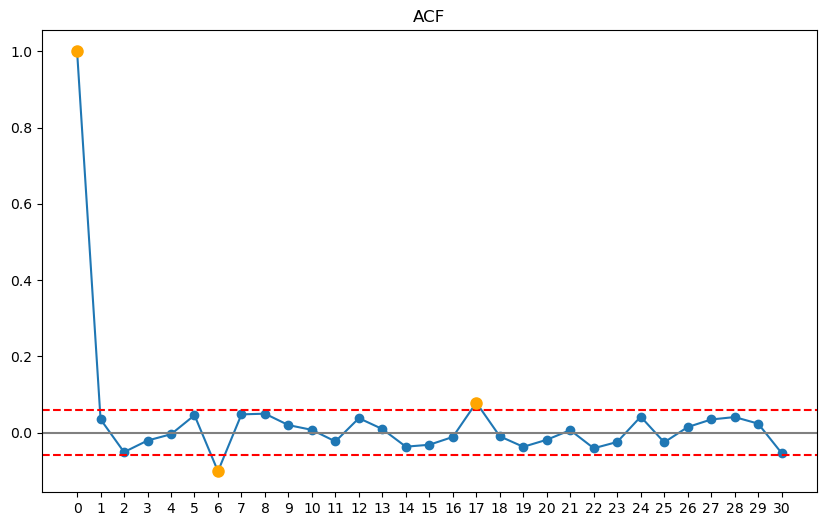

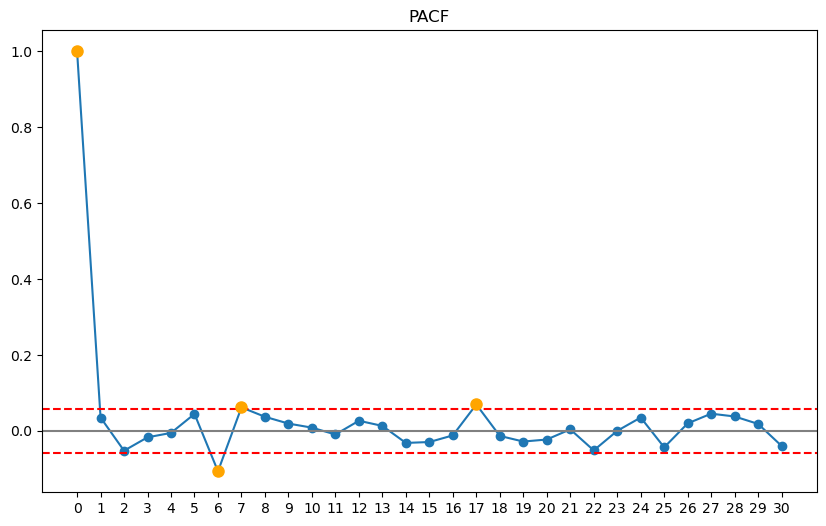

In [6]:
#6. From ACF and PACF, we determine the lists of p and q
acf_plot= acf(diff['close'])
pacf_plot= pacf(diff['close'])
limit_sig = (math.exp(2 * 1.96 / math.sqrt(len(diff['close']) - 3))-1) / (math.exp(2 * 1.96 / math.sqrt(len(diff['close']) - 3)) + 1)
list_q=[]
list_p=[]

# Plot ACF
plt.figure(figsize=(10, 6))
N = len(diff['close'])  
plt.plot(acf_plot, marker='o', linestyle='-') 
plt.axhline(y=0, color="gray")
plt.axhline(y=limit_sig, color='red', linestyle='--') 
plt.axhline(y=-limit_sig, color='red', linestyle='--')
plt.xticks(np.arange(0, 31, step=1))
for i, val in enumerate(acf_plot):
    if val > limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_q.append(i)
    if val < -limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_q.append(i)
plt.title('ACF')

# Plot PACF
plt.figure(figsize=(10, 6))
plt.plot(pacf_plot, marker='o', linestyle='-') 
plt.axhline(y=0, color="gray")
plt.axhline(y=limit_sig, color='red', linestyle='--') 
plt.axhline(y=-limit_sig, color='red', linestyle='--')
plt.xticks(np.arange(0, 31, step=1))
for i, val in enumerate(pacf_plot):
    if val > limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_p.append(i)
    if val < -limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_p.append(i)
plt.title('PACF')

In [7]:
#7. Therefore, in addition to selecting the p and d values identified by PACF and ACF,we will also take additional p and d values from 0 to 9 and put them to the list_p and list_d
combined_p = set(list_p).union(range(0, 10))
list_p = list(combined_p)
combined_q = set(list_q).union(range(0, 10))
list_q = list(combined_q)

In [8]:
#8. Train the model with the new lists of p and q
signi_models = []
best_model = []
best_rmse = float('inf')

for p_value in list_p:
    for q_value in list_q:
        try:
            model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(p_value, diff_order, q_value)).fit()
            p_values = model_arimax.pvalues
            if all(p < 0.05 for p in p_values):
                signi_models.append((p_value, q_value))
            else:
                raise Exception("Model not significant")
            pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
            rmse = np.sqrt(mean_squared_error(y_test_a, pred_test_a))
            if rmse < best_rmse:
                best_model = (p_value, q_value)
                best_rmse = rmse
        except Exception as e:
            pass

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\states

In [9]:
#9. Print the list of models that have statistical significance and the model with the lowest rmse from this list
print("List model have statistical significance:")
for model_params in signi_models:
    print("- p_value:", model_params[0], ", d_value:", diff_order, ", q_value:", model_params[1])    
print("\nBest model: p=", best_model[0], ", d=", diff_order, ", q=", best_model[1])

List model have statistical significance:
- p_value: 0 , d_value: 1 , q_value: 0
- p_value: 0 , d_value: 1 , q_value: 1
- p_value: 0 , d_value: 1 , q_value: 3
- p_value: 1 , d_value: 1 , q_value: 0
- p_value: 2 , d_value: 1 , q_value: 0
- p_value: 3 , d_value: 1 , q_value: 0
- p_value: 4 , d_value: 1 , q_value: 0
- p_value: 5 , d_value: 1 , q_value: 0
- p_value: 6 , d_value: 1 , q_value: 0
- p_value: 7 , d_value: 1 , q_value: 0
- p_value: 8 , d_value: 1 , q_value: 0
- p_value: 9 , d_value: 1 , q_value: 0

Best model: p= 0 , d= 1 , q= 1


In [10]:
#10. Define and fit model with train data
model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(best_model[0], diff_order,best_model[1])).fit()
print(model_arimax.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1126
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9310.213
Date:                Wed, 29 May 2024   AIC                          18628.426
Time:                        11:09:16   BIC                          18648.528
Sample:                             0   HQIC                         18636.022
                               - 1126                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.5739      0.010     54.719      0.000       0.553       0.594
low            0.4182      0.010     40.947      0.000       0.398       0.438
ma.L1         -0.9782      0.009   -106.346      0.0

# RNN

In [11]:
#11. Scaler data for RNN model
data_rnn=data.reset_index()['close']
scaler=MinMaxScaler(feature_range=(0,1))
data_rnn=scaler.fit_transform(np.array(data_rnn).reshape(-1,1))

In [12]:
#12. Split the data into train and test sets
train_size = int(ratio * len(data_rnn))
test_size = len(data_rnn) - train_size
train_rnn = data_rnn[:train_size]
test_rnn = data_rnn[train_size:]

In [13]:
#13. Function to create a dataset for RNN model
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
#14. Reshape into X=t,t+1,t+2..t+99 [samples, time steps, features] and Y=t+100 [samples]
time_step = 100
x_train_rnn, y_train_rnn = create_dataset(train_rnn, time_step)
x_test_rnn, y_test_rnn = create_dataset(test_rnn, time_step)
x_train_rnn =x_train_rnn.reshape(x_train_rnn.shape[0],x_train_rnn.shape[1] , 1)
x_test_rnn = x_test_rnn.reshape(x_test_rnn.shape[0],x_test_rnn.shape[1] , 1)

In [15]:
#15. Proceed to define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(Dropout(0.5))  
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error',optimizer='adam')

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
#16. Fit model with train data
model_rnn.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),epochs=50,batch_size=32,verbose=1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.5774 - val_loss: 0.0181
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1545 - val_loss: 0.0033
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1013 - val_loss: 0.0011
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0601 - val_loss: 4.5186e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0471 - val_loss: 0.0023
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0598 - val_loss: 4.4205e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0355 - val_loss: 3.7705e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0323 - val_loss: 2.7795e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0263 - val_loss: 0.0013
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0248 - val_loss: 2.1854e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0178 - val_loss: 2.4845e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 

# Linear Regression

In [17]:
#17. Prepare train data for LR Model using predictions on train data from ARIMAX and RNN Models
pred_train_a = model_arimax.predict(start= len(x_train_a), end=len(x_train_a) * 2 -1 , exog=exg_train_a)
pred_train_rnn=model_rnn.predict(x_train_rnn)
pred_train_rnn=scaler.inverse_transform(pred_train_rnn)
df_pred_train_a = pd.DataFrame({'arima': pred_train_a[(time_step+1):]}).reset_index().drop('index', axis=1)
df_pred_train_rnn = pd.DataFrame(pred_train_rnn, columns=['rnn'])

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [18]:
#18.Fit a model with inputs being the predictions of ARIMAX models, RNN model, and two features "high" and "low"
x_train_lr = pd.concat([df_pred_train_a, df_pred_train_rnn,exg_train_a[(time_step+1):].reset_index().drop(['index'], axis=1)], axis=1)
y_train_lr = y_train_a[(time_step+1):]
model_lr= LinearRegression()
model_lr.fit(x_train_lr, y_train_lr)

LinearRegression()

In [19]:
#19. Prepare test data for LR model using predictions on test data from ARIMAX and RNN models
pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
pred_test_rnn=model_rnn.predict(x_test_rnn)
pred_test_rnn=scaler.inverse_transform(pred_test_rnn)
df_pred_test_a = pd.DataFrame({'arima': pred_test_a[(time_step+1):]}).reset_index().drop('index', axis=1)
df_pred_test_rnn = pd.DataFrame(pred_test_rnn, columns=['rnn'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [20]:
#20. Predict on the test data 
x_test_lr = pd.concat([df_pred_test_a, df_pred_test_rnn,exg_test_a[(time_step+1):].reset_index().drop(['index'], axis=1)], axis=1)
y_test_lr = y_test_a[(time_step+1):]
pred_test_lr = model_lr.predict(x_test_lr)

In [21]:
#21. Evaluate model performance using RMSE, MAPE, and MSLE
print("ARIMAX Model")
rmse = np.sqrt(mean_squared_error(pred_test_a[(time_step+1):],y_test_lr))
mape = mean_absolute_percentage_error(pred_test_a[(time_step+1):],y_test_lr) * 100
msle = mean_squared_log_error(pred_test_a[(time_step+1):],y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

print("\nRNN Model")
rmse = np.sqrt(mean_squared_error(pred_test_rnn,y_test_lr))
mape = mean_absolute_percentage_error(pred_test_rnn,y_test_lr) * 100
msle = mean_squared_log_error(pred_test_rnn,y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

print("\nStacking Model")
rmse = np.sqrt(mean_squared_error(pred_test_lr,y_test_lr))
mape = mean_absolute_percentage_error(pred_test_lr,y_test_lr) * 100
msle = mean_squared_log_error(pred_test_lr,y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

ARIMAX Model
RMSE: 425.11420365727037
MAPE: 0.3460702836627996 %
MSLE: 1.652442963895713e-05

RNN Model
RMSE: 678.6788056710551
MAPE: 0.5017497603147995 %
MSLE: 4.215046830322141e-05

Stacking Model
RMSE: 462.6655655697373
MAPE: 0.369705165255272 %
MSLE: 1.9673028443725717e-05


In [22]:
#22. Function is used to predict the high and low columns for the next 30, 60, 90 days because the ARIMAX model requires exogenous variables
def predict_by_rnn(data_rnn):
    scaler=MinMaxScaler(feature_range=(0,1))
    data_rnn=scaler.fit_transform(np.array(data_rnn).reshape(-1,1))
    
    train_size = int(ratio * len(data_rnn))
    test_size = len(data_rnn) - train_size
    train_rnn = data_rnn[:train_size]
    test_rnn = data_rnn[train_size:]
    
    time_step = 100
    x_train_rnn, y_train_rnn = create_dataset(train_rnn, time_step)
    x_test_rnn, y_test_rnn = create_dataset(test_rnn, time_step)
    x_train_rnn =x_train_rnn.reshape(x_train_rnn.shape[0],x_train_rnn.shape[1] , 1)
    x_test_rnn = x_test_rnn.reshape(x_test_rnn.shape[0],x_test_rnn.shape[1] , 1)
    
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(time_step, 1)))
    model_rnn.add(Dropout(0.5))  
    model_rnn.add(SimpleRNN(128))
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error',optimizer='adam')
    model_rnn.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),epochs=50,batch_size=32,verbose=1)
      
    x_input=test_rnn[-(time_step+1):].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    lst_output=[]
    n_steps=100
    i=0
    while(i<90):

        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model_rnn.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model_rnn.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    pred_rnn=scaler.inverse_transform(lst_output)
    
    return pred_rnn


In [23]:
#23. Predict high and low for the next 30, 60, 90 days
high_pred_rnn = predict_by_rnn(data.reset_index()['high'])
low_pred_rnn = predict_by_rnn(data.reset_index()['low'])   

Epoch 1/50


C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5287 - val_loss: 0.0091
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1664 - val_loss: 0.0062
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0970 - val_loss: 0.0019
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0634 - val_loss: 3.4060e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0460 - val_loss: 1.2906e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0394 - val_loss: 1.5677e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0334 - val_loss: 1.8951e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0309 - val_loss: 5.0258e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0285 - val_loss: 6.2049e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0257 - val_loss: 8.5543e-05
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0178 - val_loss: 1.1835e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.6434 - val_loss: 0.0179
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1862 - val_loss: 0.0014
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0940 - val_loss: 0.0011
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0525 - val_loss: 7.4363e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0607 - val_loss: 7.2402e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0365 - val_loss: 5.5264e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0283 - val_loss: 2.6339e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0275 - val_loss: 2.1003e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0257 - val_loss: 6.7785e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0220 - val_loss: 3.9748e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0182 - val_loss: 1.8954e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [24]:
#24. Predict close for the next 30, 60, 90 days by ARIMAX model
df_high_pred_rnn = pd.DataFrame(high_pred_rnn, columns=['high'])
df_low_pred_rnn = pd.DataFrame(low_pred_rnn, columns=['low'])
exg_pred_a = pd.concat([df_high_pred_rnn, df_low_pred_rnn], axis=1)
close_pred_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + 89, exog=exg_pred_a)

In [25]:
#25. Predict close for the next 30, 60, 90 days by RNN model
x_input=test_rnn[-(time_step+1):].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps=100
i=0
while(i<90):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model_rnn.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_rnn.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
close_pred_rnn=scaler.inverse_transform(lst_output)

In [26]:
#26. Predict close for the next 30, 60, 90 days by Stacking model [(ARIMAX + RNN) --> LR]
df_close_pred_a  = pd.DataFrame({'arima': close_pred_a}).reset_index().drop('index', axis=1)
df_close_pred_rnn  = pd.DataFrame(close_pred_rnn, columns=['rnn'])
x_pred_lr = pd.concat([df_close_pred_a,df_close_pred_rnn,df_high_pred_rnn,df_low_pred_rnn], axis=1)
close_pred_stacking = model_lr.predict(x_pred_lr)

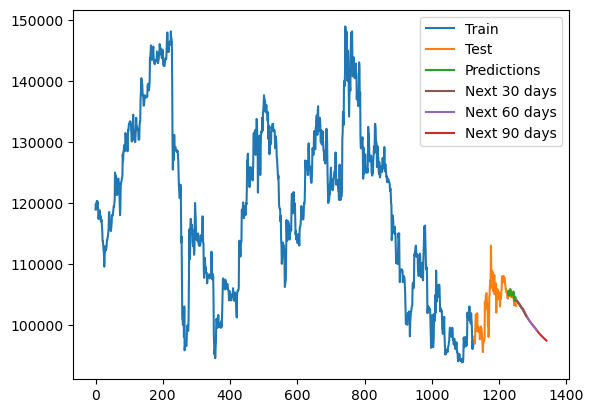

In [27]:
#27. Draw the plot 
train_index = pd.RangeIndex(start=0, stop=train_size, step=1)
line1, = plt.plot(train_index, y_train_a, label="Train")

test_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
line2, = plt.plot(test_index, y_test_a, label="Test")

pred_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
line3, = plt.plot(pred_index, pred_test_lr, label="Predictions")

pred90_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
line4, = plt.plot(pred90_index, close_pred_stacking, label="Next 90 days")

pred60_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
line5, = plt.plot(pred60_index, close_pred_stacking[:60], label="Next 60 days")

pred30_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
line6, = plt.plot(pred30_index, close_pred_stacking[:30], label="Next 30 days")

plt.legend(handles=[line1, line2, line3, line6, line5, line4])
plt.savefig("D:\Tài liệu PTDLKD\Image_Result\Stacking_VJC_91.png")
plt.show()